In [ ]:
# ----------------------------------------------------------------------------
# Title: Assignment 11.2
# Author: Surenther Selvaraj
# Date: 23 Nov 2025
# Modified By: Surenther Selvaraj
# Description: Building a CNN Image Classifier
# Data: https://www.kaggle.com/code/amyjang/tensorflow-mnist-cnn-tutorial
# ----------------------------------------------------------------------------

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
import itertools

### Load the MNIST data set using PyTorch

In [ ]:
# 1. Define a transform to convert the image to a PyTorch Tensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

# 2. Load the Training Data
train_dataset = datasets.MNIST(
    root='./data',           # Directory to store the data
    train=True,              # Specify training dataset
    download=True,           # Download the data if not present
    transform=transform      # Apply the transformation
)

# 3. Load the Test Data
test_dataset = datasets.MNIST(
    root='./data',
    train=False,             # Specify test dataset
    download=True,
    transform=transform
)

# 4. Create DataLoaders
batch_size = 64
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"PyTorch Training Dataset Size: {len(train_dataset)}")
print(f"PyTorch Test Dataset Size: {len(test_dataset)}")

100%|██████████| 9.91M/9.91M [00:02<00:00, 4.22MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 498kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 997kB/s] 
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.81MB/s]

PyTorch Training Dataset Size: 60000
PyTorch Test Dataset Size: 10000


### Display the first five images in the training data set.

First five labels in the batch:
[3 4 0 3 3]
-----------------------------------
Corresponding digits displayed below:


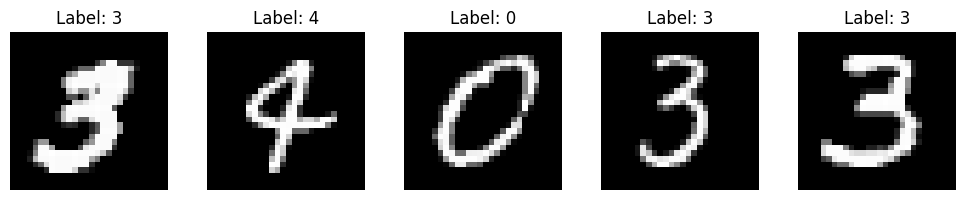

In [ ]:
# 1. Get the first batch of data from the training loader
for images, labels in train_loader:
    # We only need the first batch, so we break after the loop.
    # The batch size was set to 64, so this retrieves 64 images.
    break

# 2. Iterate through the first 5 images in the batch
fig, axes = plt.subplots(1, 5, figsize=(10, 2))

# Define the normalization parameters used previously for un-normalizing
mean = 0.1307
std = 0.3081

print("First five labels in the batch:")
print(labels[:5].numpy())
print("-" * 35)
print("Corresponding digits displayed below:")

for i in range(5):
    # Get the i-th image tensor (shape: [1, 28, 28])
    image_tensor = images[i]

    # Un-normalize the image for correct visual display:
    # image_tensor * std + mean
    image_display = image_tensor * std + mean

    # Convert the tensor to a NumPy array for Matplotlib,
    # and remove the channel dimension (1) to get shape (28, 28)
    image_np = image_display.squeeze().numpy()

    # Display the image
    axes[i].imshow(image_np, cmap='gray')
    axes[i].set_title(f"Label: {labels[i].item()}")
    axes[i].axis('off') # Hide axes ticks and labels

plt.tight_layout()
plt.show()

### Build and train a CNN classifier on the MNIST training

Using device: cpu
Data loaded: Training samples=60000, Test samples=10000

Starting Training...
Train Epoch: 1 [6336/60000 (11%)]	Loss: 0.440406
Train Epoch: 1 [12736/60000 (21%)]	Loss: 0.341464
Train Epoch: 1 [19136/60000 (32%)]	Loss: 0.273221
Train Epoch: 1 [25536/60000 (43%)]	Loss: 0.242450
Train Epoch: 1 [31936/60000 (53%)]	Loss: 0.246171
Train Epoch: 1 [38336/60000 (64%)]	Loss: 0.102582
Train Epoch: 1 [44736/60000 (75%)]	Loss: 0.126135
Train Epoch: 1 [51136/60000 (85%)]	Loss: 0.112771
Train Epoch: 1 [57536/60000 (96%)]	Loss: 0.097910
--- Epoch 1 complete. Avg Loss: 0.3317 ---
Train Epoch: 2 [6336/60000 (11%)]	Loss: 0.098357
Train Epoch: 2 [12736/60000 (21%)]	Loss: 0.168979
Train Epoch: 2 [19136/60000 (32%)]	Loss: 0.173303
Train Epoch: 2 [25536/60000 (43%)]	Loss: 0.176470
Train Epoch: 2 [31936/60000 (53%)]	Loss: 0.114284
Train Epoch: 2 [38336/60000 (64%)]	Loss: 0.155157
Train Epoch: 2 [44736/60000 (75%)]	Loss: 0.045575
Train Epoch: 2 [51136/60000 (85%)]	Loss: 0.032811
Train Epoch: 

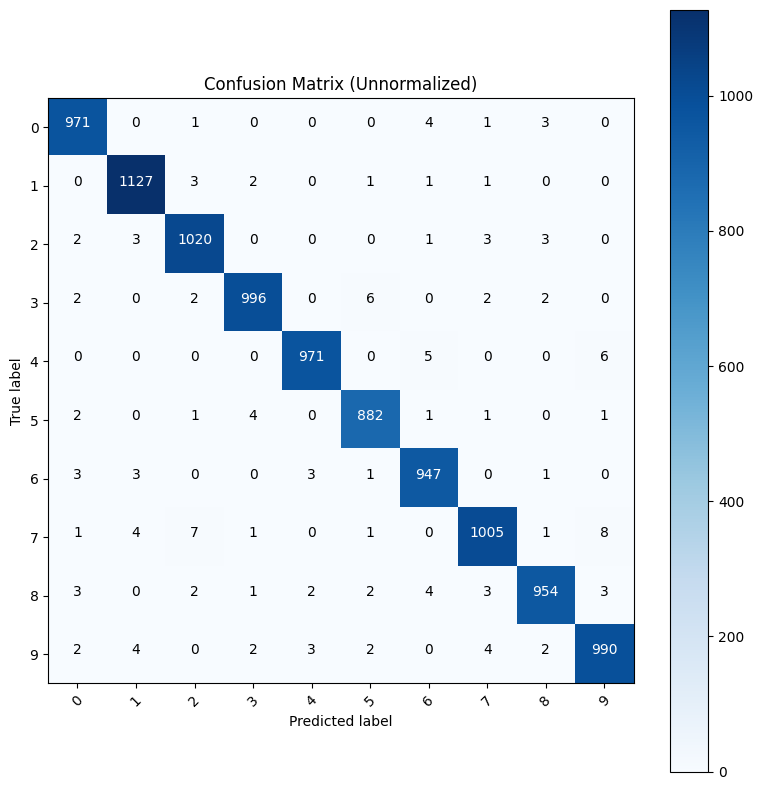


Model saved to 'mnist_cnn_model.pth'


In [8]:
# --- 1. CONFIGURATION AND HYPERPARAMETERS ---
# Determine the device to use (GPU or CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
LEARNING_RATE = 0.001
BATCH_SIZE = 64
NUM_EPOCHS = 3
NUM_CLASSES = 10 # Digits 0-9

# --- 2. DATA LOADING AND PREPROCESSING ---
def load_data(batch_size):
    """Loads and preprocesses the MNIST data, returning DataLoaders."""
    # MNIST global mean and standard deviation for normalization
    mean, std = 0.1307, 0.3081
    
    # Define transformations: Convert to tensor and normalize
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((mean,), (std,))
    ])

    # Load the datasets (download=True ensures it's available)
    train_dataset = datasets.MNIST(
        root='./data', train=True, download=True, transform=transform
    )
    test_dataset = datasets.MNIST(
        root='./data', train=False, download=True, transform=transform
    )

    # Create DataLoaders for batch processing.
    train_loader = DataLoader(
        dataset=train_dataset, batch_size=batch_size, shuffle=True
    )
    test_loader = DataLoader(
        dataset=test_dataset, batch_size=batch_size, shuffle=False
    )
    
    print(f"Data loaded: Training samples={len(train_dataset)}, Test samples={len(test_dataset)}")
    return train_loader, test_loader

# --- 3. CNN ARCHITECTURE DEFINITION ---
class ConvNet(nn.Module):
    """
    A simple Convolutional Neural Network for MNIST classification.
    """
    def __init__(self, num_classes=10):
        super(ConvNet, self).__init__()
        
        # First convolutional block: CONV -> ReLU -> MaxPool
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5) 
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        # Second convolutional block: CONV -> ReLU -> MaxPool
        self.conv2 = nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5) 
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) 
        
        self.dropout = nn.Dropout(0.5)

        # Fully Connected Layer: Input size 20*4*4=320 features
        self.fc = nn.Linear(20 * 4 * 4, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        
        # Flatten the feature maps (retains batch size)
        x = x.view(x.size(0), -1) 
        
        x = self.dropout(x)
        x = self.fc(x)
        return x

# --- 4. TRAINING FUNCTION ---
def train(model, train_loader, criterion, optimizer, epoch):
    """Trains the model for one epoch."""
    model.train() # Set the model to training mode
    running_loss = 0.0
    for batch_idx, (data, targets) in enumerate(train_loader):
        data = data.to(device)
        targets = targets.to(device)

        # Forward pass and loss calculation
        scores = model(data)
        loss = criterion(scores, targets)

        # Backward pass (optimization)
        optimizer.zero_grad() 
        loss.backward()       
        optimizer.step()      

        running_loss += loss.item()

        # Print training status periodically
        if (batch_idx + 1) % 100 == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} '
                  f'({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')
            
    avg_loss = running_loss / len(train_loader)
    return avg_loss

# --- 5. ACCURACY CHECK & PREDICTION COLLECTION ---
def check_accuracy(model, loader):
    """Evaluates the model's accuracy on a given DataLoader and collects predictions."""
    model.eval() # Set model to evaluation mode
    num_correct = 0
    num_samples = 0
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device)
            y = y.to(device)
            
            scores = model(x)
            _, predictions = scores.max(1) 
            
            num_correct += (predictions == y).sum().item()
            num_samples += y.size(0)

            # Collect predictions and labels
            all_preds.extend(predictions.cpu().numpy())
            all_labels.extend(y.cpu().numpy())

    accuracy = num_correct / num_samples
    print(f'Test Accuracy: {num_correct}/{num_samples} ({100. * accuracy:.2f}%)')
    
    return accuracy, np.array(all_labels), np.array(all_preds)

# --- 6. CONFUSION MATRIX VISUALIZATION ---
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        # Calculate the percentage of misclassification along the rows (true labels)
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.figure(figsize=(8, 8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    # Format the matrix values
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    # 
    plt.show()

# --- 7. MAIN EXECUTION ---
if __name__ == "__main__":
    print(f"Using device: {device}")
    
    # Load data
    train_loader, test_loader = load_data(BATCH_SIZE)
    
    # Initialize network, loss function, and optimizer
    model = ConvNet(NUM_CLASSES).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
    
    print("\nStarting Training...")

    # Training loop (Ensuring the model is trained before evaluation)
    for epoch in range(1, NUM_EPOCHS + 1):
        loss = train(model, train_loader, criterion, optimizer, epoch)
        print(f"--- Epoch {epoch} complete. Avg Loss: {loss:.4f} ---")

    # Final Evaluation & Prediction Collection
    print("\nTraining Finished. Checking final accuracy on the Test Set:")
    final_accuracy, y_true, y_pred = check_accuracy(model, test_loader)
    
    # --- STEP: Display Confusion Matrix ---
    print("\nGenerating Confusion Matrix...")
    classes = [str(i) for i in range(NUM_CLASSES)]
    plot_confusion_matrix(y_true, y_pred, classes=classes, title='Confusion Matrix (Unnormalized)')
    
    # Save the trained model state
    torch.save(model.state_dict(), "mnist_cnn_model.pth")
    print("\nModel saved to 'mnist_cnn_model.pth'")

### Summary
This Jupyter notebook details the complete process of building and training a Convolutional Neural Network (CNN) classifier for the MNIST handwritten digit dataset using the PyTorch framework. The workflow begins by importing essential deep learning and metrics libraries (PyTorch, torchvision, and sklearn). The MNIST data is then loaded, converted into PyTorch tensors, and normalized, with an initial visualization confirming the integrity of the first five images and their labels. The custom ConvNet class defines the CNN architecture, featuring two convolutional layers with ReLU activation and max-pooling, a dropout layer for regularization, and a final linear layer for 10-class output. The model is initialized, compiled using the Adam optimizer (learning rate 0.001) and CrossEntropyLoss, and trained efficiently over 3 epochs. Upon completion of training, the model achieves a high classification accuracy of 98.63% on the test set, and a detailed Confusion Matrix is then calculated and displayed to visually analyze the model's performance and precisely identify any remaining digit misclassifications.